In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from copy import copy
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score

# Dataset

classic credit scoring binary classification dataset. downloaded from https://www.kaggle.com/datasets/uciml/german-credit

In [2]:
objects = 100
df = pd.read_csv('data/german_credit_data.csv', index_col=0)[:objects]

In [3]:
target = df['Risk'].astype('category').cat.codes
df_bool = df['Sex'].astype('category').cat.codes
df_bool.name = 'Sex'
df['Job'] = df['Job'].astype('category')
df_cat = pd.get_dummies(df[['Job', 'Saving accounts', 'Checking account', 'Purpose']])
df_num = df[['Age', 'Credit amount', 'Duration']]
df_bool = pd.concat([df_bool, df_cat], axis=1)

<AxesSubplot: >

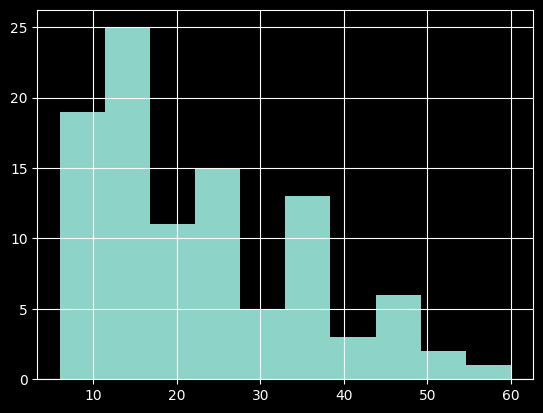

In [4]:
df_num['Duration'].hist()

<AxesSubplot: >

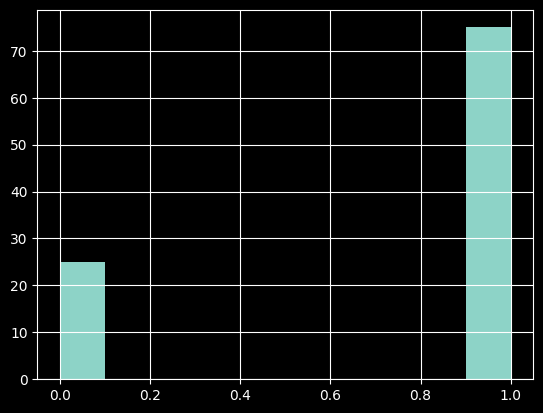

In [5]:
target.hist()

unbalanced labels -> use fscore (or whole coufusion matrix)

In [6]:
from src.utils import DataCollection
from sklearn.preprocessing import KBinsDiscretizer

binarizer = KBinsDiscretizer(strategy='uniform')
data = DataCollection(df_bool.values, df_num.values, target.values, binarizer=binarizer)

# Model

provided code did not work as intended, so i had to rewrite it almost entirely. new sourse code for ConceptNetwork is available in src/model.py

it was also refactored into a normal pytorch module, thus made more flaxible.

In [7]:
import fcapy
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
from fcapy.poset import POSet

from src.model import ConceptNetwork

In [71]:
K_train = FormalContext(data.x['train'].numpy().astype(bool), target=data.y['train'].numpy().astype(bool))
L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=10, is_monotone=True)

In [72]:
def select_best_concepts(lattice, context, measure='f1_score', n_concepts=10):
    lattice_ = copy(lattice)
    for concept in lattice_:
        y_preds = np.zeros(context.n_objects)
        y_preds[list(concept.extent_i)] = 1
        concept.measures['f1_score'] = f1_score(context.target, y_preds)
        concept.measures['support'] = concept.support

    best_concepts = lattice_.measures[measure].argsort()[::-1][:n_concepts]

    if len({g_i for c in lattice_[best_concepts] for g_i in c.extent_i}) != context.n_objects:
        raise ValueError("Selected concepts do not cover all train objects")
    return lattice[best_concepts]

In [73]:
# best_concepts = select_best_concepts(L_train, K_train, measure='support', n_concepts=20)
best_concepts = L_train
cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)

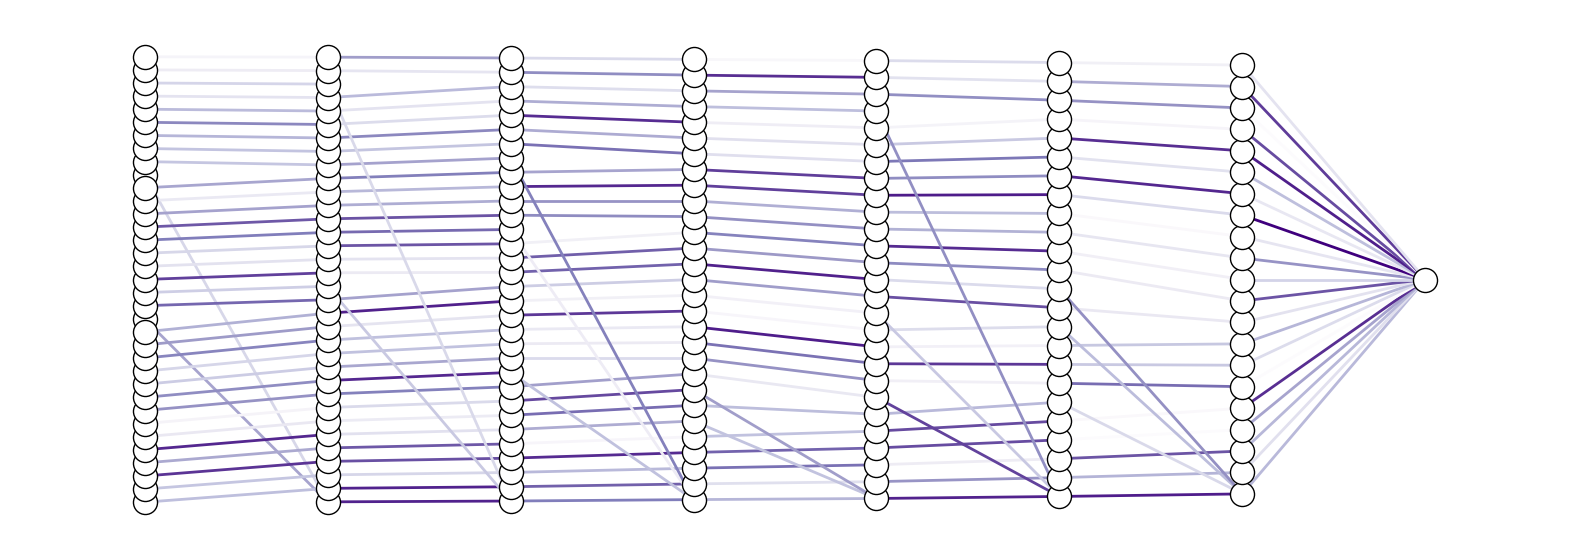

In [74]:
fig = plt.figure(figsize=(20,7))
cn.plot_network(edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

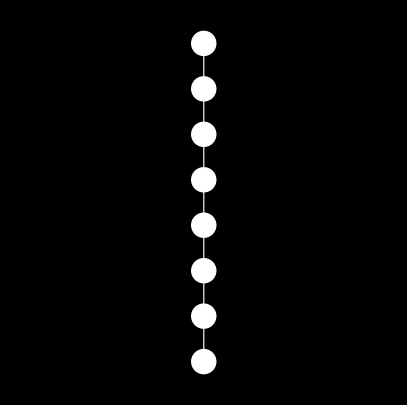

In [75]:
fig, ax = plt.subplots(figsize=(5,5))
vis = LineVizNx(node_border_color='g', node_color='w')
vis.draw_poset(POSet(best_concepts), ax=ax);

## Training

In [77]:
cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)

In [78]:
def train(model, data, epochs=1000, lr=1e-3, weight_decay=0):
    x = data.x['train']
    y = data.y['train'][:,None]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCELoss()

    losses = []
    for t in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return losses

In [79]:
losses = train(cn, data, epochs=5000, lr=1e-3)

100%|██████████| 5000/5000 [01:07<00:00, 73.87it/s] 


0.5623350739479065


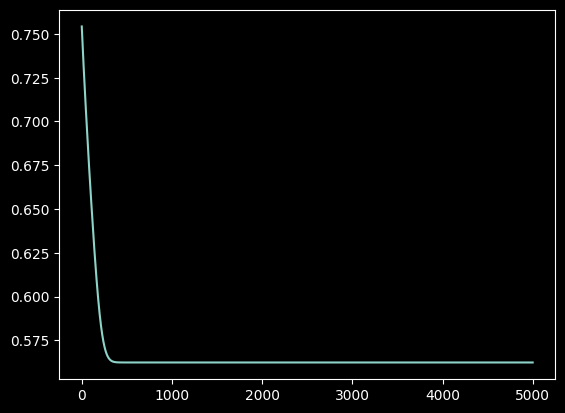

In [80]:
plt.plot(losses)
print(losses[-1])

In [81]:
x_val = data.x['val']
y_val = data.y['val'][:,None]
with torch.no_grad():
    y_pred = cn(x_val) > 0.5
    print(f1_score(y_pred, y_val))

0.8571428571428571


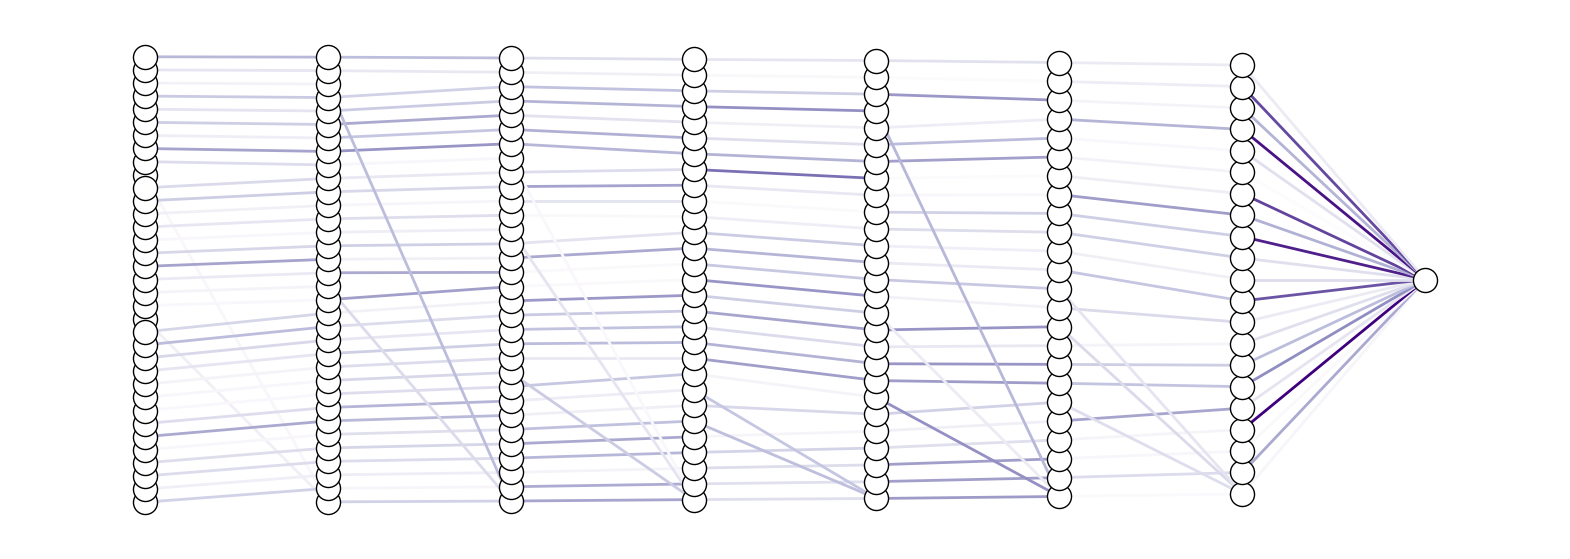

In [82]:
fig = plt.figure(figsize=(20,7))
cn.plot_network(edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

# Experiments

In [23]:
# погонять эксперименты на колво концептов и нелинейности
# придумать что-то с бинаризацией
# 
# завтра:
# описать датасет
# написать почему фскор
# написать репорт

In [83]:
x_val = data.x['val']
y_val = data.y['val'][:,None]

for act in [nn.ReLU, nn.Tanh, nn.Sigmoid]:
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=act)
    train(cn, data, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(act.__name__, f1_score(y_pred, y_val))

100%|██████████| 5000/5000 [00:49<00:00, 101.81it/s]


ReLU 0.8571428571428571


100%|██████████| 5000/5000 [01:12<00:00, 69.20it/s] 


Tanh 0.7586206896551724


100%|██████████| 5000/5000 [00:45<00:00, 110.36it/s]

Sigmoid 0.8571428571428571


In [68]:
for s in ['uniform', 'quantile']:
    binarizer = KBinsDiscretizer(strategy=s)
    data_ = DataCollection(df_bool.values, df_num.values, target.values, binarizer=binarizer)
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)
    train(cn, data_, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(s, f1_score(y_pred, y_val))

100%|██████████| 5000/5000 [00:53<00:00, 93.31it/s] 


uniform 0.8571428571428571


100%|██████████| 5000/5000 [00:31<00:00, 157.27it/s]

quantile 0.8571428571428571


In [70]:
for c in [10,20,30,40,50,100]:
    K_train = FormalContext(data.x['train'].numpy().astype(bool), target=data.y['train'].numpy().astype(bool))
    L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=c, is_monotone=True)
    best_concepts = L_train
    print(len(best_concepts))
    torch.manual_seed(1)
    cn = ConceptNetwork(best_concepts, nonlinearity=nn.ReLU)
    train(cn, data_, epochs=5000, lr=1e-3)
    with torch.no_grad():
        y_pred = cn(x_val) > 0.5
        print(c, f1_score(y_pred, y_val))

8


100%|██████████| 5000/5000 [00:44<00:00, 112.71it/s]


10 0.8571428571428571
19


100%|██████████| 5000/5000 [01:37<00:00, 51.37it/s]


20 0.8571428571428571
29


100%|██████████| 5000/5000 [01:09<00:00, 71.69it/s] 


30 0.8571428571428571
25


100%|██████████| 5000/5000 [01:10<00:00, 70.82it/s] 


40 0.8571428571428571
47


100%|██████████| 5000/5000 [01:25<00:00, 58.39it/s]


50 0.8571428571428571
100


 18%|█▊        | 902/5000 [00:21<01:39, 41.17it/s]


KeyboardInterrupt: 

# Other model comparison

knn, random forests, boosting, mlp, tabnet

couldnt make abything to work with a reasonable amount of effort, due to this field being so underdeveloped

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [84]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(data.x['train'], data.y['train'])
print(f1_score(knn.predict(data.x['val']), data.y['val']))

knn_num = KNeighborsClassifier(n_neighbors=50)
knn_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(knn_num.predict(data.x_num['val']), data.y['val']))


0.8571428571428571
0.8571428571428571


In [91]:
rf = RandomForestClassifier(n_estimators=200, random_state=1)
rf.fit(data.x['train'], data.y['train'])
print(f1_score(rf.predict(data.x['val']), data.y['val']))

rf_num = RandomForestClassifier(n_estimators=200, random_state=1)
rf_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(rf_num.predict(data.x_num['val']), data.y['val']))

0.8125
0.8484848484848485


In [92]:
lr = LogisticRegression()
lr.fit(data.x['train'], data.y['train'])
print(f1_score(lr.predict(data.x['val']), data.y['val']))

lr_num = LogisticRegression()
lr_num.fit(data.x_num['train'], data.y['train'])
print(f1_score(lr_num.predict(data.x_num['val']), data.y['val']))

0.7741935483870969
0.8387096774193549


In [86]:
mlp = MLPClassifier(hidden_layer_sizes=[128,128,128,32], max_iter=1000, learning_rate_init=1e-3, random_state=1, n_iter_no_change=100)
mlp.fit(data.x['train'], data.y['train'])
f1_score(mlp.predict(data.x['val']), data.y['val'])

0.8000000000000002

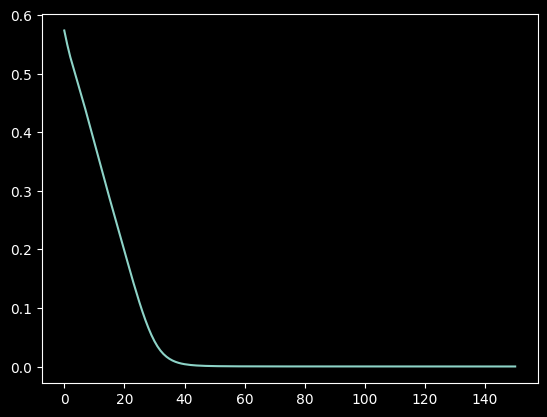

In [87]:
plt.plot(mlp.loss_curve_)